In [13]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
path_binario = '../modelos/modelo_binario_final'
path_multiclase = '../modelos/modelo_multi_final'

tokenizer_bin = AutoTokenizer.from_pretrained(path_binario)
model_bin = AutoModelForSequenceClassification.from_pretrained(path_binario).to('cuda')

tokenizer_mul = AutoTokenizer.from_pretrained(path_multiclase)
model_mul = AutoModelForSequenceClassification.from_pretrained(path_multiclase).to('cuda')


In [15]:
def clasificar_codigo(texto):

    inputs_bin = tokenizer_bin(
        texto,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to("cuda")

    with torch.no_grad():
        logits_bin = model_bin(**inputs_bin).logits

    pred_bin = torch.argmax(logits_bin, dim=1).item()

    if pred_bin == 0:
        return 0

    inputs_mul = tokenizer_mul(
        texto,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to("cuda")

    with torch.no_grad():
        logits_mul = model_mul(**inputs_mul).logits

    pred_mul = torch.argmax(logits_mul, dim=1).item()

    id2label_multi = {
        0: 1,
        1: 7,
        2: 10
    }

    return id2label_multi[pred_mul]



In [16]:
test_set = pd.read_parquet('/content/drive/MyDrive/Proyecto_PLN/task_b_test_set_sample.parquet')
test_set.head()

,code,generator,label,language
0,"import React from ""react"";\nimport { Dropdown,...",Human,0,JavaScript
1,import json\nimport logging\nimport requests\n...,GPT-4o-mini,10,Python
2,bool Cy_USBPD_FRS_Recv_Enable(cy_stc_usbpd_con...,meta-llama/Llama-3.2-90B-Vision-Instruct,7,C
3,"(n, m) = map(int, input().split())\ns = ''\na ...",Human,0,Python
4,import pygame\nimport socket\nimport threading...,GPT-4o-mini,10,Python


In [17]:
val_set = pd.read_parquet('/content/drive/MyDrive/Proyecto_PLN/task_b_validation_set.parquet')
val_set.head()

,code,generator,label,language
0,def put_webhooks(\n webhook_cls: WebhookTyp...,Human,0,Python
1,def check_time_dist(\n move_data: DataFrame...,Human,0,Python
2,package com.nexosis.DataSetTests;\n\nimport co...,Human,0,Java
3,"def partition(num_list, start, end):\n\tsplit ...",Human,0,Python
4,"func (w *Watcher) Watch(pid int, flags uint32)...",Human,0,Go


In [18]:
test_set = test_set[['code', 'label']]
test_set = test_set[test_set['label'].isin([0,1,7,10])]
counts = test_set['label'].value_counts()
counts

,count
label,
0,474
10,214
7,61
1,21


In [19]:
test_set['label'].unique()

array([ 0, 10,  7,  1])

In [20]:
val_set=val_set[val_set['label'].isin([0,1,7,10])]

testfinal = val_set
testfinal.head()

,code,generator,label,language
0,def put_webhooks(\n webhook_cls: WebhookTyp...,Human,0,Python
1,def check_time_dist(\n move_data: DataFrame...,Human,0,Python
2,package com.nexosis.DataSetTests;\n\nimport co...,Human,0,Java
3,"def partition(num_list, start, end):\n\tsplit ...",Human,0,Python
4,"func (w *Watcher) Watch(pid int, flags uint32)...",Human,0,Go


In [21]:
human_samples_original = val_set[val_set['label'] == 0].copy()

val_set_non_human = val_set[val_set['label'].isin([1,7,10])][['code', 'label']].copy()

n = len(val_set_non_human)

sampled_human_val = pd.DataFrame(columns=['code', 'label'])

sampled_human_val = human_samples_original.sample(n=n, random_state=42)

val_set = pd.concat([sampled_human_val, val_set_non_human])
val_set.head()

,code,generator,label,language
15697,class InForLoop {\n void test(int i) {\n if ...,Human,0,Java
18008,@Override\n\tpublic void onStart()\n\t{\n\t\ti...,Human,0,Java
47438,package com.comcast.pop.modules.queue.aws.sqs....,Human,0,Java
86862,"@RequestMapping(path = { ""/restaurant/add"" }, ...",Human,0,Java
75751,auto InboundConnectionRequest(CommandId id) {\...,Human,0,C++


In [22]:
testfinal = pd.concat([val_set, test_set])

testfinal['label'].value_counts()

,count
label,
0,5170
10,2368
7,1756
1,868


In [23]:
testfinal['pred_label'] = testfinal['code'].apply(clasificar_codigo)


In [24]:
print(testfinal['label'].unique())
print(testfinal['pred_label'].unique())


[ 0  1  7 10]
[ 0  1  7 10]


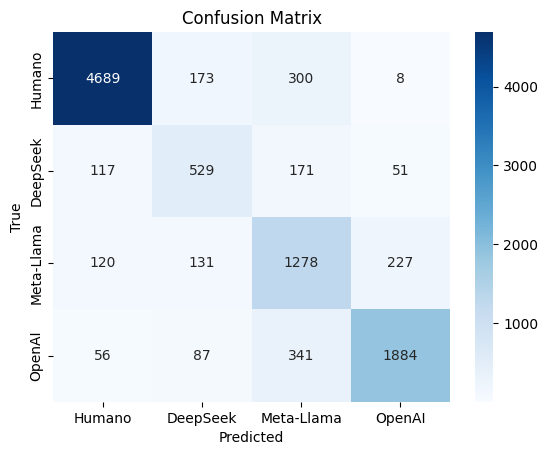

In [25]:

label_names = {
    0: "Humano",
    1: "DeepSeek",
    7: "Meta-Llama",
    10: "OpenAI"
}


cm = confusion_matrix(testfinal['label'], testfinal['pred_label'])


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_names[i] for i in [0,1,7,10]],
            yticklabels=[label_names[i] for i in [0,1,7,10]])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [26]:
#Metricas

accuracy = accuracy_score(testfinal['label'], testfinal['pred_label'])
print(f"Accuracy: {accuracy}")

classification_rep = classification_report(testfinal['label'], testfinal['pred_label'])
print("Classification Report:\n", classification_rep)

#

Accuracy: 0.8246408187364692
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      5170
           1       0.57      0.61      0.59       868
           7       0.61      0.73      0.66      1756
          10       0.87      0.80      0.83      2368

    accuracy                           0.82     10162
   macro avg       0.75      0.76      0.75     10162
weighted avg       0.84      0.82      0.83     10162

